### Use a SOM to construct feature likelihood

In [114]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import abc

In [3]:
class MapGeometry(abc.ABC):
    
    def __init__(self, size):
        self._size = size
        self._separations = None
    
    @property
    def size(self):
        """The flattened size of this map.
        """
        return self._size
    
    @property
    def separations(self):
        """The matrix of pairwise separations between map nodes.
        
        Uses lazy evaluation.  The matrix might be sparse.
        """
        if self._separations is None:
            self._separations = self._calculate_separations()
        return self._separations
    
    @abc.abstractmethod
    def _calculate_separations(self):
        raise NotImplementedError()
        
    @abc.abstractmethod
    def plot(self, values, ax=None, **kwargs):
        """Plot a representation of the specified values for this map.
        
        Parameters
        ----------
        values : array
            1D array of length :attr:`size`    
        ax : matplotlib axis or None
            Plot axis to use, or create a default axis when None.
        kwargs : dict
            Additional plot keyword arguments to pass to the implementation.
        """
        raise NotImplementedError()

In [4]:
class Grid(MapGeometry):
    
    def __init__(self, *signature, metric='L2'):
        """Create a rectilinear grid map geometry.
        
        The grid shape is specified by the absolute values of the signature.        
        A negative value in the signature indicates that distances along the
        corresponding axis are calculated using wrap around.
        """
        shape = [abs(k) for k in signature]
        x = np.empty(shape=shape)
        super(Grid, self).__init__(x.size)
        self._shape = x.shape
        self._wrap = [k < 0 for k in signature]
        if metric not in ('L0', 'L1', 'L2'):
            raise ValueError('Invalid metric "{metric}", should be one of L0, L1, L2.')
        self._metric = metric
        
    @property
    def shape(self):
        return self._shape
    
    @property
    def wrap(self):
        return self._wrap
    
    @property
    def metric(self):
        return self._metric
    
    def _calculate_separations(self):
        ndim = len(self.shape)
        separation = np.zeros(self.shape + self.shape)
        # Loop over axes.
        for k, wrapk in enumerate(self._wrap):
            nk = self.shape[k]
            xk = np.arange(nk)
            # Calculate the the (nk, nk) matrix of absolute integer separations along the k-th axis.
            dxk = np.abs(xk.reshape(nk, 1) - xk)
            if wrapk:
                W = dxk > nk // 2
                dxk[W] *= -1
                dxk[W] += nk
            # Add this axis' contribution to the separation matrix.
            S = [(nk if (j % ndim == k) else 1) for j in range(2 * ndim)]
            dxk = dxk.reshape(S)
            if self._metric == 'L2':
                separation += dxk ** 2
            elif self._metric == 'L1':
                separation += dxk
            elif self._metric == 'L0':
                separation = np.maximum(separation, dxk)
        if self._metric == 'L2':
            # Take sqrt in place.
            np.sqrt(separation, out=separation)
        return separation.reshape(self.size, self.size)
    
    def plot(self, values, ax=None, **kwargs):
        """Plot an image of the input values.
        
        If the grid dimension is > 2, show a slice in the largest
        2 dimensions.
        """
        ndim = len(self.shape)
        if ndim == 1:
            # Plot a single row of values.
            values = values.reshape(1, self.size)
        elif ndim > 2:
            # Plot a slice in the largest 2 dimensions.
            largest = np.argsort(self.shape)[-2:]
            idx = [slice(None) if k in largest else 1 for k in range(ndim)]
            values = values[idx]
        ax = ax or plt.gca()
        ny, nx = values.shape
        ax.imshow(values, interpolation='none', origin='lower',
                  extent=[-0.5, nx - 0.5, -0.5, ny - 0.5], **kwargs)
        ax.axis('off')

In [146]:
class SelfOrganizingMap(object):
    
    def __init__(self, mapgeom):
        self._mapgeom = mapgeom
        
    def fit(self, data, errs, maxiter=100, eta=0.5, init='random', seed=123):
        data = np.asarray(data)
        errs = np.asarray(errs)
        N, D = data.shape
        assert (N, D) == errs.shape
        self._winner = np.empty(N, np.uint32)
        rng = np.random.RandomState(seed)
        if init == 'random':
            sigmas = np.std(data, axis=0)
            self._weights = sigmas.reshape(-1, 1) * rng.normal(size=(D, self._mapgeom.size))
        else:
            raise ValueError('Invalid init "{}".'.format(init))
        # Calculate mean separation between grid points as a representative large scale.
        large_scale = np.mean(self._mapgeom.separations)
        # Calculate the mean separation between N uniformly distributed points in D dimensions
        # as a representative small scale.
        volume = np.prod(self._mapgeom.shape)
        small_scale = (volume / N) ** (1 / D)
        assert small_scale < large_scale, 'Check the scales!'
        scale = large_scale
        dscale = (small_scale / large_scale) ** (1 / maxiter)
        for i in range(maxiter):
            loss = 0.
            for j, (x,y) in enumerate(zip(data,errs)):
                # Calculate the Euclidean data-space distance squared between x and
                # each map site's weight vector.
                #dx = x.reshape(-1, 1) - self._weights
                #distsq = np.sum(dx ** 2, axis=0)
                
                # Calculate the reduced X^2 distance between training object x and
                # the cell weight vector
                dx = x.reshape(-1,1) - self._weights
                distsq = (1 / D) * np.sum((dx ** 2) / (y.reshape(-1,1) ** 2), axis=0)
                
                # Find the map site with the smallest distance (largest dot product).
                self._winner[j] = k = np.argmin(distsq)
                # The loss is the sum of smallest (data space) distances for each data point.
                loss += np.sqrt(distsq[k])
                # Update all weights (dz are map-space distances).
                dz = self._mapgeom.separations[k]
                self._weights += eta * np.exp(-0.5 * (dz / scale) ** 2) * dx
            yield i, loss
            # Lower the scale for the next iteration.
            scale *= dscale

In [6]:
from astropy.table import Table
import time

In [7]:
def u_matrix(som):
    
    '''Add option to interpolate onto finer grid
    
    From p. 337 of this paper https://link.springer.com/content/pdf/10.1007%2F978-3-642-15381-5.pdf'''
    
    rows, cols, D = som.shape
    
    u_matrix = np.empty((rows, cols))
    
    for i in range(rows):
        for j in range(cols):
            dist = 0
            ## neighbor above
            if i < rows - 1:
                dist += np.sqrt(np.sum((som[i,j] - som[i+1,j]) ** 2))
            ## neighbor below
            if i > 0:
                dist += np.sqrt(np.sum((som[i,j] - som[i-1,j]) ** 2))
            ## neighbor left
            if j > 0:
                dist += np.sqrt(np.sum((som[i,j] - som[i,j-1]) ** 2))
            ## neighbor right
            if j < cols - 1:
                dist += np.sqrt(np.sum((som[i,j] - som[i,j+1]) ** 2))
            u_matrix[i,j] = np.sum(dist)

                
    ## interpolate u_matrix onto (2X-1) x (2Y-1) grid
    #x = np.arange(0,rows - interp_int, interp_int)
    #y = np.arange(0,cols - interp_int, interp_int)
            
    return(u_matrix)

In [120]:
def galaxy_demo(colors, errs, nmap=-50, niter=100, eta=0.1):
    
    # Build the self-organizing map.
    som = SelfOrganizingMap(Grid(nmap, nmap))
    losses = []
    for it, loss in som.fit(colors, errs, maxiter=niter, eta=eta):
        losses.append(loss)
        
    N, D = colors.shape

    # Plot the results.
    fig, ax = plt.subplots(2, 1, figsize=(8, 16))
    img = som._weights.T
    img = (img - img.min(axis=0)) / (img.max(axis=0) - img.min(axis=0))
    u_map = u_matrix(img.reshape(abs(nmap), abs(nmap), D))
    ax[0].imshow(u_map, interpolation='none', origin='lower', cmap='viridis')
    ax[0].axis('off')
    ax[1].plot(losses, 'ko')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Training Loss')
    plt.tight_layout()
    
    return(img.reshape(abs(nmap), abs(nmap), D))

gc_data_mag_cut = Table.read('../../../pz/cosmoDC2_small/cosmoDC2_mag_coord_cut.fits', format='ascii')
select_ra = np.logical_and(gc_data_mag_cut['ra'] >= 65.4, gc_data_mag_cut['ra'] < 65.8)
gc_ra_cut = gc_data_mag_cut[select_ra]
select_dec = np.logical_and(gc_ra_cut['dec'] >= -44.4, gc_ra_cut['dec'] < -44.)
gc_cut = gc_ra_cut[select_dec]

In [9]:
from GCR import GCRQuery
import GCRCatalogs    

In [10]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [58]:
# Select 4 deg x 4 deg patch

deg = 4
alpha = 0.78 # cos <DEC>
beta = (0.5 * deg) * (1/alpha - 1)

ra_min = 62.5 - beta
ra_max = 66.5 + beta
dec_min = -41.
dec_max = -37.
#dec_min = -46. * 0.8
#dec_max = -44. * 0.8

# Need to compensate for loss in area due to ra * cos(dec) correction (3D -> 2D)?
#ra_min /= np.cos(dec_max * np.pi / 180)
#ra_max /= np.cos(dec_max * np.pi / 180)

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]

mag_filters = [
    'mag_r < 26.3',
    'mag_i < 26.3',
]

In [12]:
gc_data_mag_cut = gc.get_quantities(['ra', 'dec', 'redshift','mag_i', 'mag_g','mag_r', 'mag_u', 'mag_y', 'mag_z'], filters=(coord_filters + mag_filters))

In [13]:
u_g = gc_data_mag_cut['mag_u'] - gc_data_mag_cut['mag_g']
g_r = gc_data_mag_cut['mag_g'] - gc_data_mag_cut['mag_r']
r_i = gc_data_mag_cut['mag_r'] - gc_data_mag_cut['mag_i']
i_z = gc_data_mag_cut['mag_i'] - gc_data_mag_cut['mag_z']
z_y = gc_data_mag_cut['mag_z'] - gc_data_mag_cut['mag_y']
redshift = gc_data_mag_cut['redshift']
colors = np.asarray([u_g, g_r, r_i, i_z, z_y, redshift]).T

#### Visualize the data as a pairplot

In [29]:
import seaborn as sns
import pandas as pd

In [121]:
df = pd.DataFrame(colors, columns=('u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'redshift'))

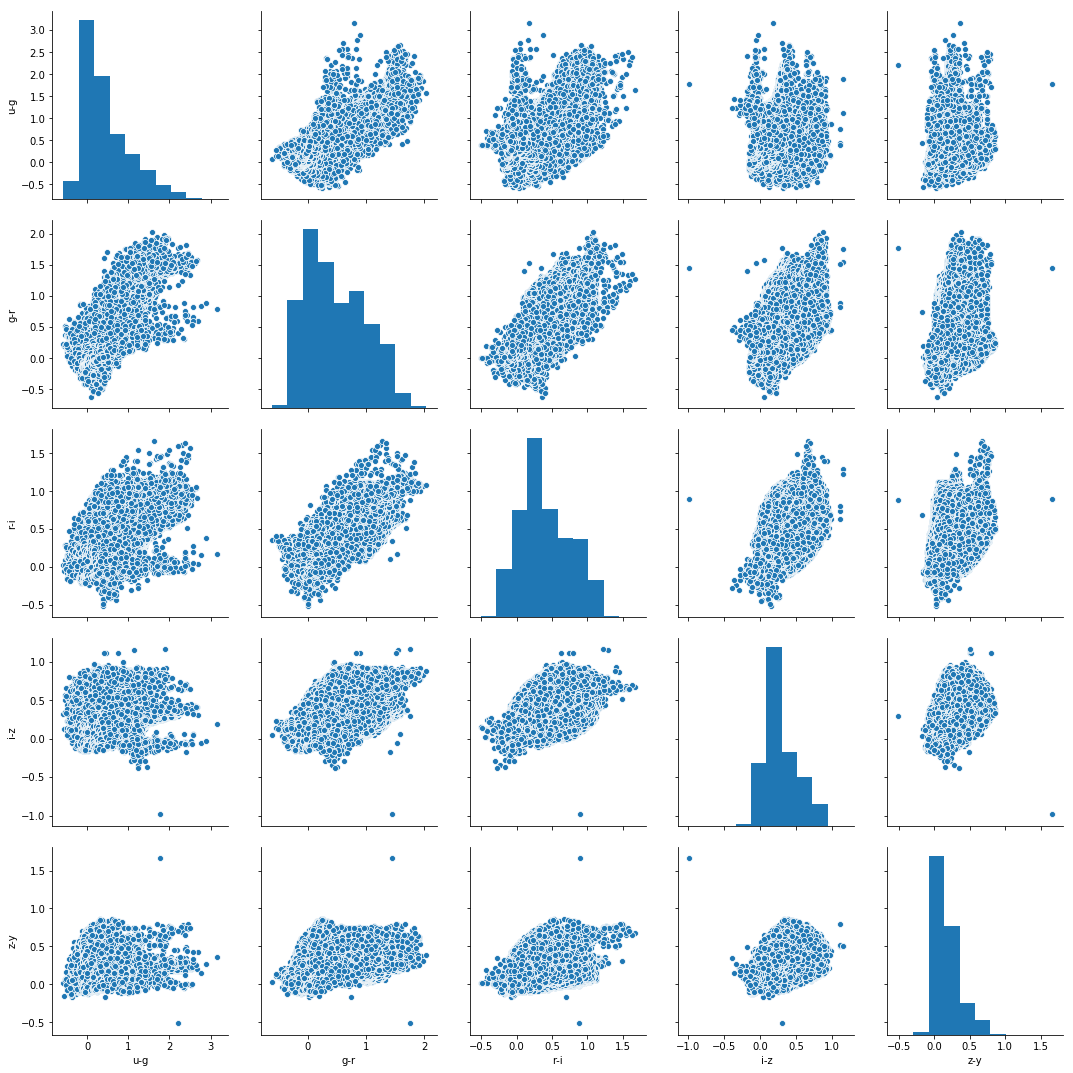

In [52]:
sns.pairplot(df.loc[::200,'u-g':'z-y'], height=3, aspect=1)

### Understand 10x10 resolution SOM grid
Run SOM on toy problem: generate random points on 2D grid and see that the SOM generated from this data is similar to the orignal data (basically does it collapse to a single cell or not)

In [17]:
rndm_2d = np.random.uniform(size=(5000,2))

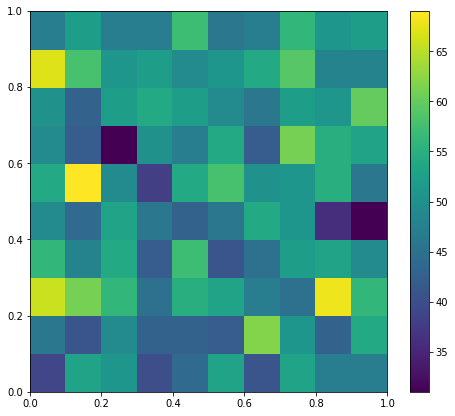

In [18]:
## Matches pretty well to SOM mapping (see below)
plt.figure(figsize=(8,7))
plt.hist2d(rndm_2d[:,0], rndm_2d[:,1], bins=10)
plt.colorbar()
plt.show()

Wrapping at boundaries:

13.23908543586731


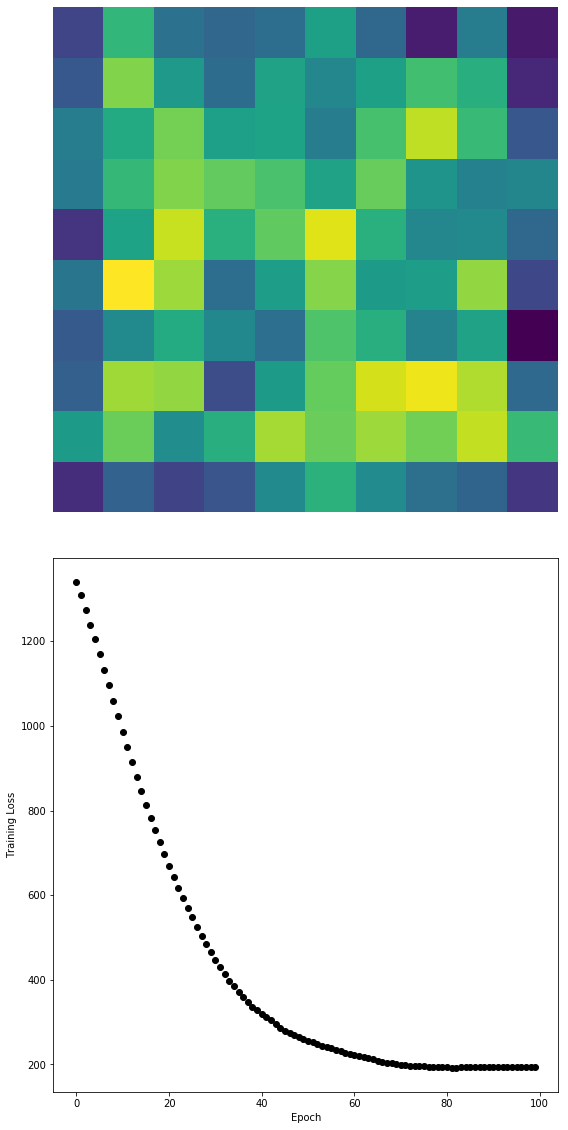

In [19]:
res = -10
start = time.time()
rndm_10 = galaxy_demo(rndm_2d, nmap=res)
print(time.time() - start)

No wrapping at boundaries:

14.243953704833984


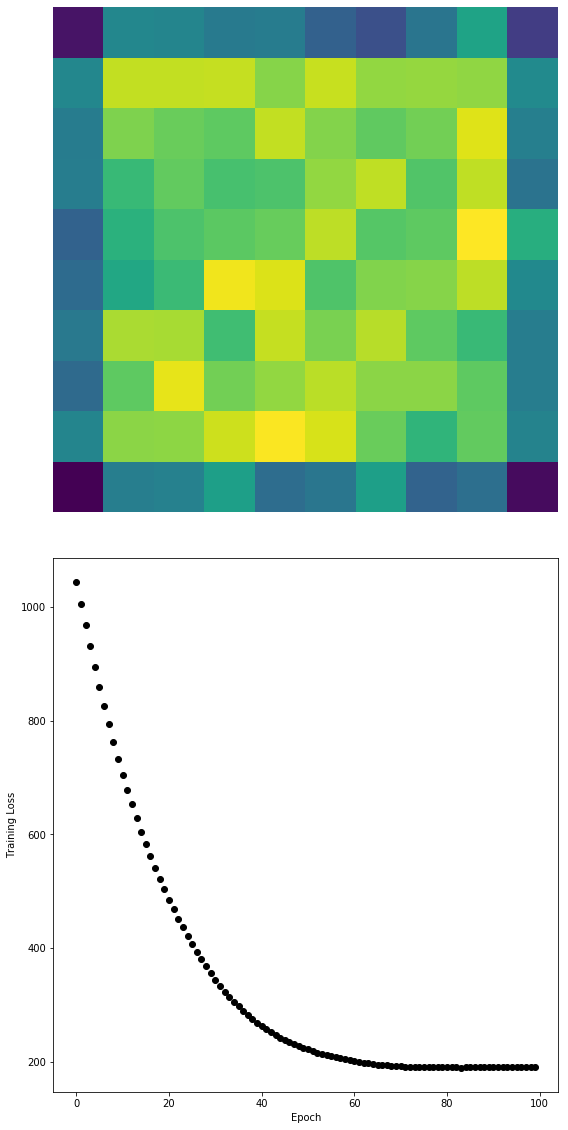

In [20]:
res = 10
start = time.time()
rndm_10_no_wrap = galaxy_demo(rndm_2d, nmap=res)
print(time.time() - start)

77.06161379814148


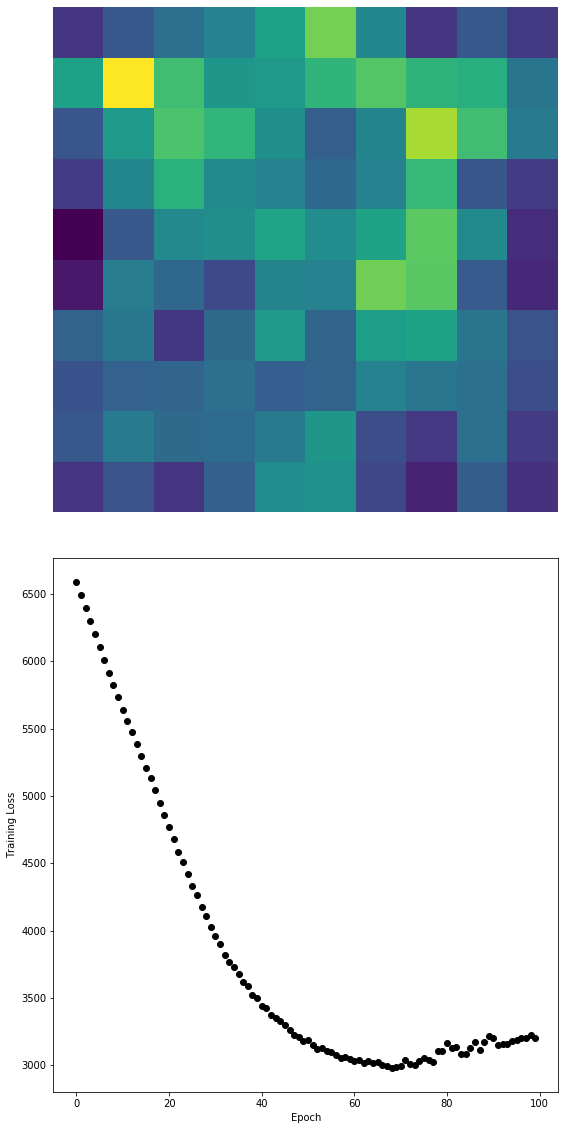

In [31]:
res = -10
start = time.time()
som_10 = galaxy_demo(df.loc[::200,'u-g':'z-y'], nmap=res)
print(time.time() - start)

- Why is training loss getting better then worse? Is it because zero is cut-off? No - looks like ~1800 is actually the smallest value...
- Is it getting worse then better because we are using too many iterations? Try with fewer (50) iterations
- I thought loss was the cumuluative sum of smallest distance between input vector and weight vector - so why is it increasing? It's because each loss value is the cumulative loss for all input vectors for a particular iteration

In [21]:
def map_rndm_to_som(data, som, statistic=np.mean):
    
    rows, cols, D = som.shape
        
    som_indices = np.empty(len(data), dtype=int)
    for i, dat in enumerate(data):
        dx = (dat - som.reshape(100,-1))
        dist = np.sqrt(np.sum(dx ** 2, axis=1))
        som_indices[i] = np.argmin(dist)
        
    counts = np.bincount(som_indices, minlength=(rows * cols))
        
    fig, axs = plt.subplots(1,3, figsize=(20,7))
    axs = axs.ravel()
        
    im0 = axs[0].imshow(counts.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis')
    fig.colorbar(im0, ax=axs[0])
    axs[0].set_title('number per SOM cell')
    
    stat1 = np.asarray([statistic(data[:,0][som_indices == i]) for i in range(rows * cols)])
    stat2 = np.asarray([statistic(data[:,1][som_indices == i]) for i in range(rows * cols)])
    
    im1 = axs[1].imshow(stat1.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis')
    fig.colorbar(im1, ax=axs[1])
    axs[1].set_title('{} of x1'.format(statistic.__name__))
    
    im2 = axs[2].imshow(stat2.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis')
    fig.colorbar(im2, ax=axs[2])
    axs[2].set_title('{} of x2'.format(statistic.__name__))
    
    plt.tight_layout()
    plt.show()

In [42]:
def map_galaxies_to_som(colors, redshifts, som, statistic=np.mean, scale=1):
    
    rows, cols, D = som.shape
    
    assert len(colors) == len(redshifts)
    
    som_indices = np.empty(len(colors), dtype=int)
    for i, dat in enumerate(colors):
        dx = (dat - som.reshape(100,-1))
        dist = np.sqrt(np.sum(dx ** 2, axis=1))
        som_indices[i] = np.argmin(dist)
        
    counts = np.bincount(som_indices, minlength=(rows * cols))
        
    fig, axs = plt.subplots(1,2, figsize=(15,7))
    axs = axs.ravel()
        
    im0 = axs[0].imshow(counts.reshape(rows,cols) / scale, origin='lower', interpolation='none', cmap='viridis')
    cbar = fig.colorbar(im0, ax=axs[0])
    if scale != 1:
        cbar.set_label('# / {}'.format(scale), labelpad=20, rotation=270)
    axs[0].set_title('number per SOM cell')
    
    # redshift values are in last column of data matrix: data[:,-1]
    stat = np.asarray([statistic(redshifts[som_indices == i]) for i in range(rows * cols)])
    im1 = axs[1].imshow(stat.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis')
    fig.colorbar(im1, ax=axs[1])
    axs[1].set_title('{} z'.format(statistic.__name__))
    
    
    #stat1 = np.asarray([statistic(data[:,0][som_indices == i]) for i in range(rows * cols)])
    #stat2 = np.asarray([statistic(data[:,1][som_indices == i]) for i in range(rows * cols)])
    
    
    #im1 = axs[1].imshow(stat1.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis')
    #fig.colorbar(im1, ax=axs[1])
    #axs[1].set_title('{} of x1'.format(statistic.__name__))
    
    #im2 = axs[2].imshow(stat2.reshape(rows,cols), origin='lower', interpolation='none', cmap='viridis')
    #fig.colorbar(im2, ax=axs[2])
    #axs[2].set_title('{} of x2'.format(statistic.__name__))
    
    plt.tight_layout()
    plt.show()
    
    return(counts)

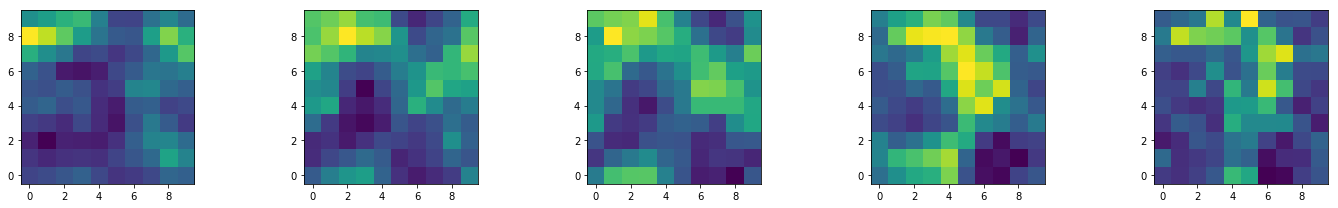

In [33]:
fig, axs = plt.subplots(1,5,figsize=(20,3))
axs = axs.ravel()

for i in range(5):
    axs[i].imshow(som_10[:,:,i], origin='lower', interpolation='none')
    
plt.tight_layout()
plt.show()

In [34]:
len(colors), np.min(colors[:,-1]), np.max(colors[:,-1])

(4631406, 0.0008889839271091216, 3.103741984361501)

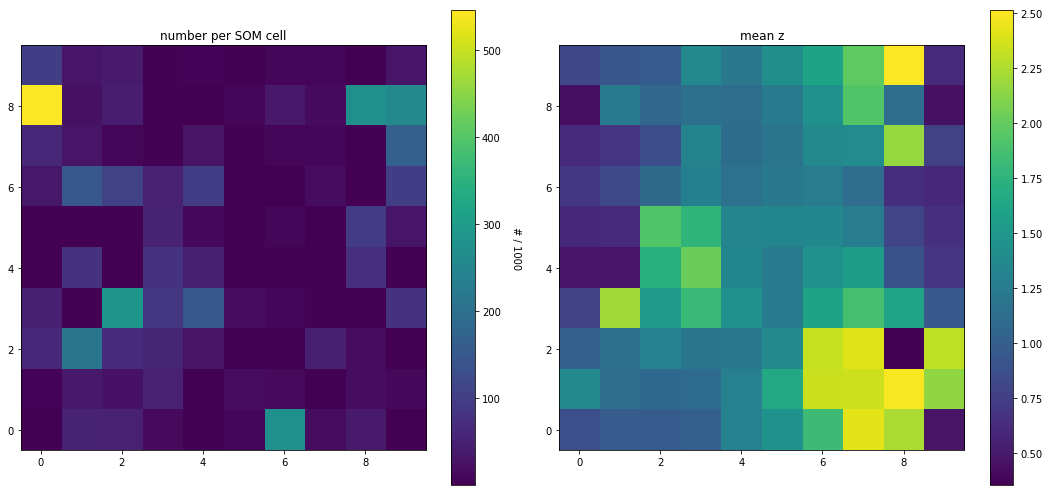

In [43]:
counts = map_galaxies_to_som(colors[:,:-1], colors[:,-1], som_10, statistic=np.mean, scale=1000)

In [44]:
counts

array([   405,  51789,  49322,  13565,   3526,   6711, 273447,  18025,
        39309,      1,   6221,  37149,  25714,  50354,   2168,  17122,
        13603,    683,  19136,  11495,  60279, 210952,  64698,  55788,
        28372,   3239,    169,  48311,  17555,    189,  47110,     45,
       287312,  89519, 151309,  18507,   8571,   3812,      8,  80651,
            1,  76938,    435,  80224,  48693,   3915,    184,    737,
        75518,   2080,    131,    570,   1094,  51562,  11764,   1117,
         7858,   1837,  94495,  30990,  34285, 149095, 105417,  50958,
        99077,    797,     25,  18052,   1717, 101569,  61151,  31065,
         7479,   2963,  28609,   3814,   6801,  10213,    400, 167870,
       545792,  24280,  43797,   2309,   1229,   9390,  37758,  15718,
       273906, 257559, 101809,  31404,  40402,   3957,   4657,    212,
         9385,   9022,    717,  30462])

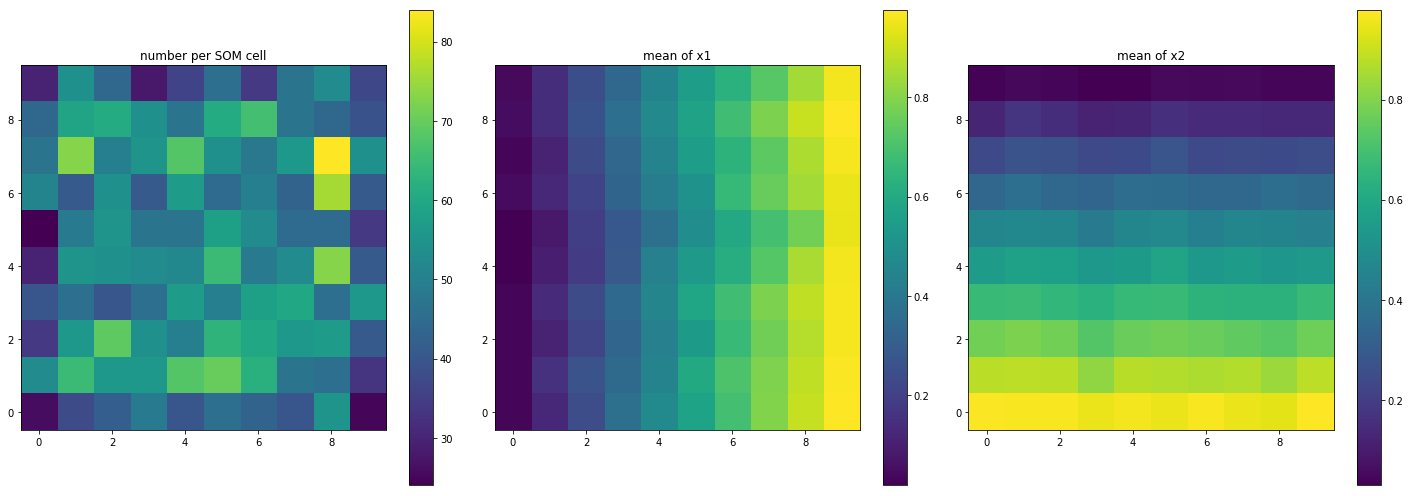

In [22]:
map_rndm_to_som(rndm_2d, rndm_10_no_wrap, statistic=np.mean)

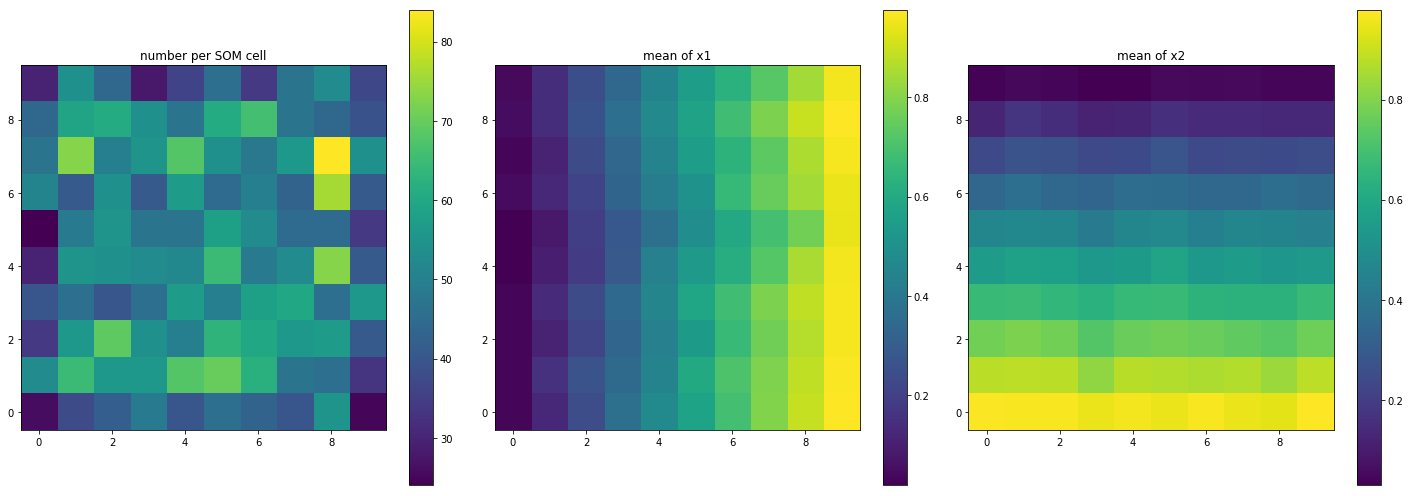

In [23]:
map_rndm_to_som(rndm_2d, rndm_10_no_wrap, statistic=np.mean)

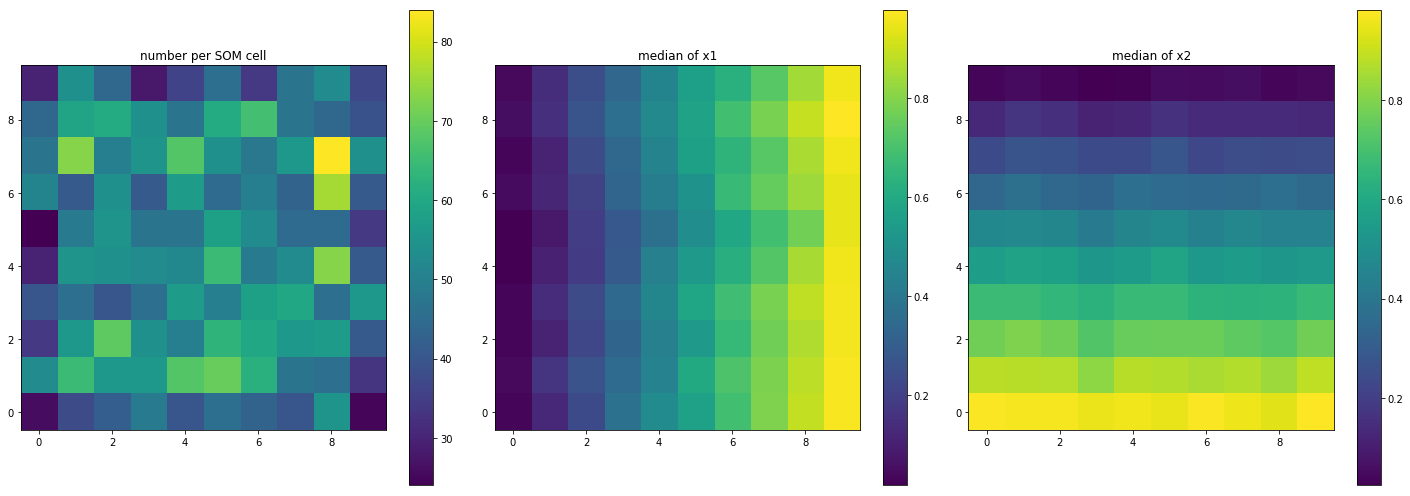

In [24]:
map_rndm_to_som(rndm_2d, rndm_10_no_wrap, statistic=np.median)

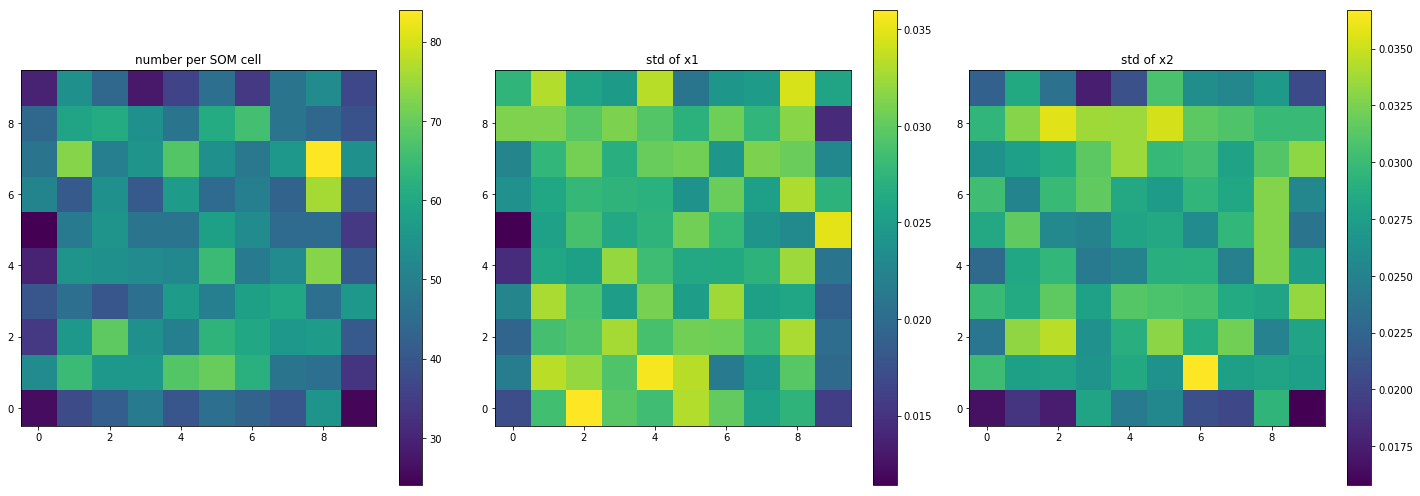

In [25]:
map_rndm_to_som(rndm_2d, rndm_10_no_wrap, statistic=np.std)

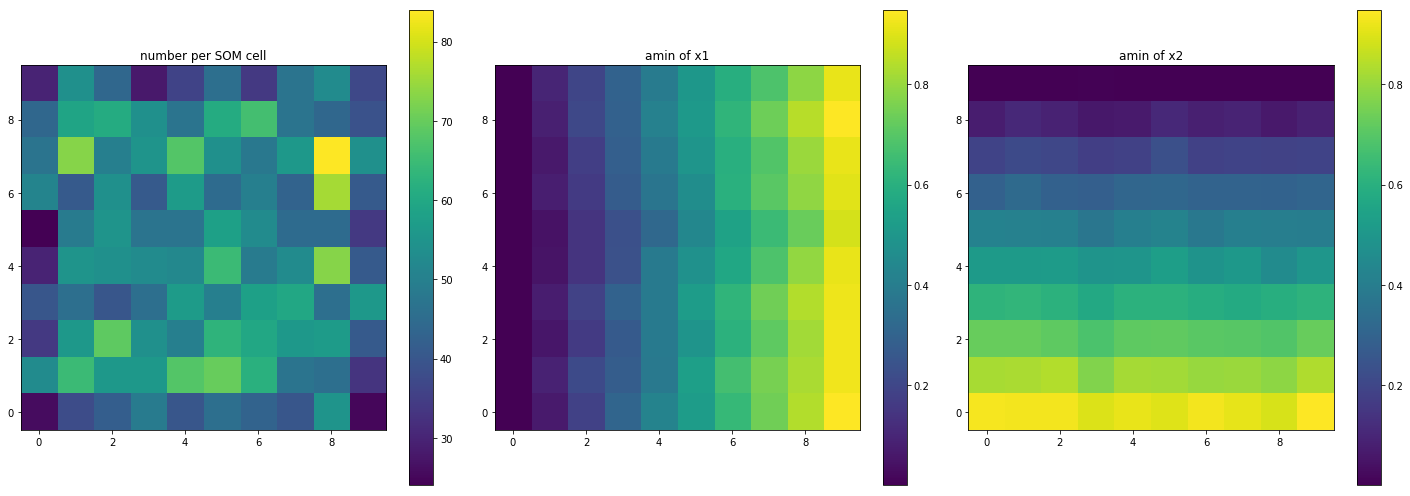

In [27]:
map_rndm_to_som(rndm_2d, rndm_10_no_wrap, statistic=np.min)

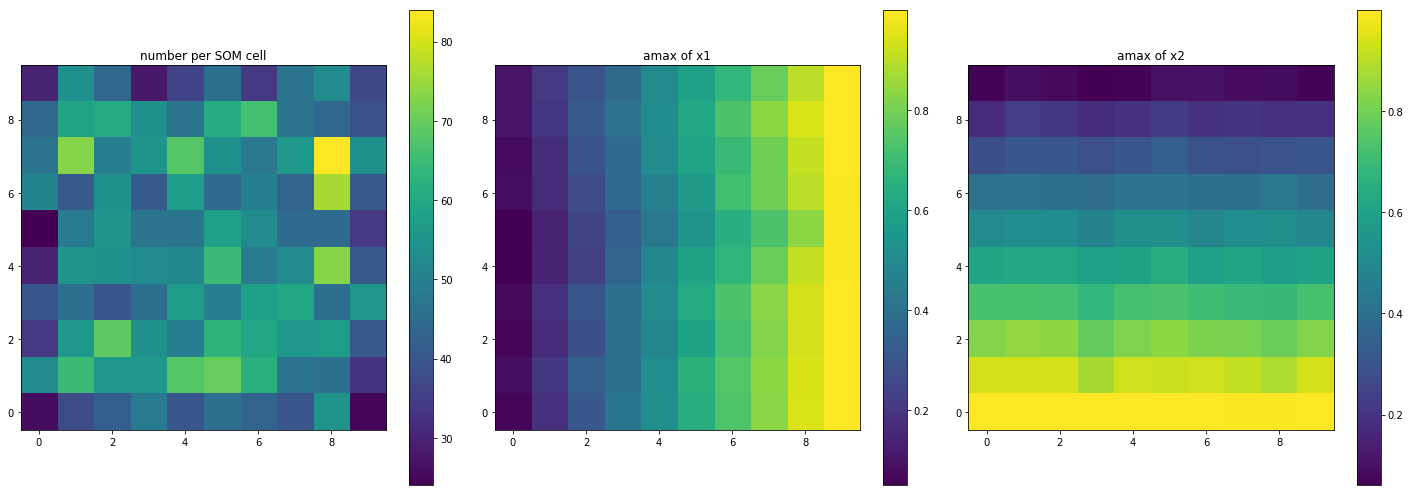

In [28]:
map_rndm_to_som(rndm_2d, rndm_10_no_wrap, statistic=np.max)

### Adding photometric errors to the SOM

Get photometric error catalog via GCR:

In [56]:
gc_err = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_photoz_magerr_10y')

In [91]:
gc_err_mag_cut = gc_err.get_quantities(['ra', 'dec', 'redshift', 'mag_i', 'mag_g','mag_r', 'mag_u', 'mag_y', 'mag_z', 'scaterr_i', 
                                   'scaterr_g', 'scaterr_r', 'scaterr_u', 'scaterr_y', 'scaterr_z'], filters=(coord_filters + mag_filters))

In [92]:
assert len(gc_data_mag_cut['ra']) == len(gc_err_mag_cut['ra'])
assert np.all(gc_data_mag_cut['ra'] == gc_err_mag_cut['ra'])

In [123]:
def propogate_mag_errs(err_band1, err_band2):
    return(np.sqrt(err_band1 ** 2 + err_band2 ** 2))

In [154]:
u = gc_err_mag_cut['mag_u']
g = gc_err_mag_cut['mag_g']
r = gc_err_mag_cut['mag_r']
i = gc_err_mag_cut['mag_i']
z = gc_err_mag_cut['mag_z']
y = gc_err_mag_cut['mag_y']

err_u = gc_err_mag_cut['scaterr_u']
err_g = gc_err_mag_cut['scaterr_g']
err_r = gc_err_mag_cut['scaterr_r']
err_i = gc_err_mag_cut['scaterr_i']
err_z = gc_err_mag_cut['scaterr_z']
err_y = gc_err_mag_cut['scaterr_y']

In [155]:
u_g = u - g
g_r = g - r
r_i = r - i
i_z = i - z
z_y = z - y

err_u_g = propogate_mag_errs(u, g)
err_g_r = propogate_mag_errs(g, r)
err_r_i = propogate_mag_errs(r, i)
err_i_z = propogate_mag_errs(i, z)
err_z_y = propogate_mag_errs(z, y)

redshifts = gc_err_mag_cut['redshift']

colors = np.asarray([u_g, g_r, r_i, i_z, z_y]).T
errs = np.asarray([err_u_g, err_g_r, err_r_i, err_i_z, err_z_y]).T

In [96]:
err_i = gc_err_mag_cut['scaterr_i'][::50]
err_g = gc_err_mag_cut['scaterr_g'][::50]
err_r = gc_err_mag_cut['scaterr_r'][::50]
err_u = gc_err_mag_cut['scaterr_u'][::50]
err_y = gc_err_mag_cut['scaterr_y'][::50]
err_z = gc_err_mag_cut['scaterr_z'][::50]

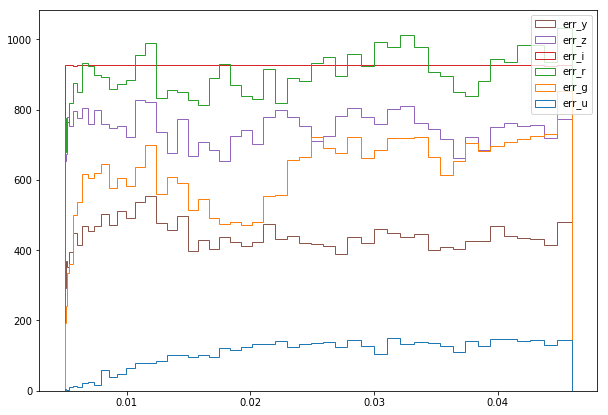

In [109]:
plt.figure(figsize=(10,7))
plt.hist([err_u, err_g, err_r, err_i, err_z, err_y], bins=np.percentile(err_i, (np.arange(50))), histtype='step', range=(0,0.5), label=['err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y'])
plt.legend()
plt.show()

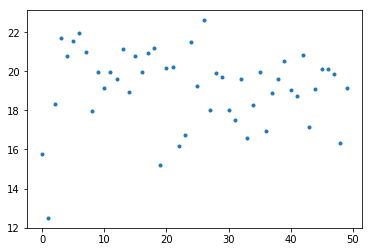

In [89]:
plt.errorbar(x=np.arange(50), y=gc_err_mag_cut['mag_i'][:50], yerr=err_i, fmt='.')
plt.show()

In [112]:
# fractional error
gc_err_mag_cut['scaterr_i'][:50] / gc_err_mag_cut['mag_i'][:50]

array([0.00031745, 0.00040004, 0.00027295, 0.00025651, 0.0002467 ,
       0.00025203, 0.00026561, 0.00024668, 0.00027846, 0.00025244,
       0.00026171, 0.00025216, 0.00025599, 0.00024706, 0.00026419,
       0.0002467 , 0.00025234, 0.00024664, 0.00024749, 0.00032857,
       0.00025033, 0.00024995, 0.00030879, 0.00029848, 0.00025151,
       0.0002603 , 0.00032744, 0.00027797, 0.00025293, 0.00025496,
       0.00027792, 0.00028565, 0.00025622, 0.00030108, 0.00027347,
       0.00025217, 0.00029544, 0.00026495, 0.00025636, 0.00024776,
       0.0002628 , 0.00026743, 0.00024661, 0.00029167, 0.00026265,
       0.00025078, 0.00025073, 0.00025354, 0.00030636, 0.00026189])

88.73564529418945


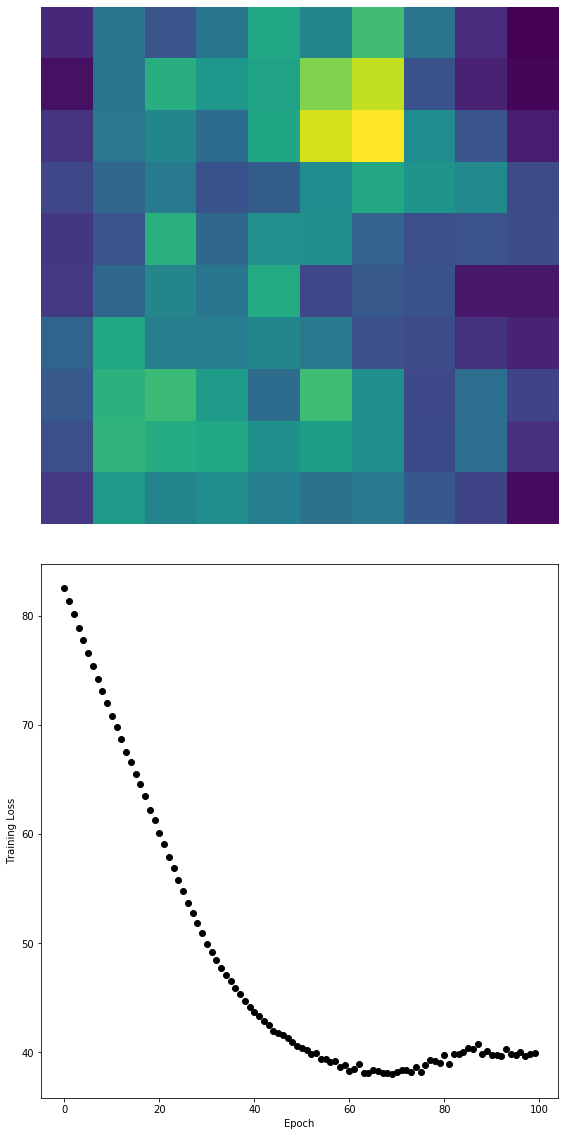

In [152]:
## Using chi-squared distance to calculated neighborhood
res = -10
start = time.time()
som_10 = galaxy_demo(colors[::200], errs[::200], nmap=res)
print(time.time() - start)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


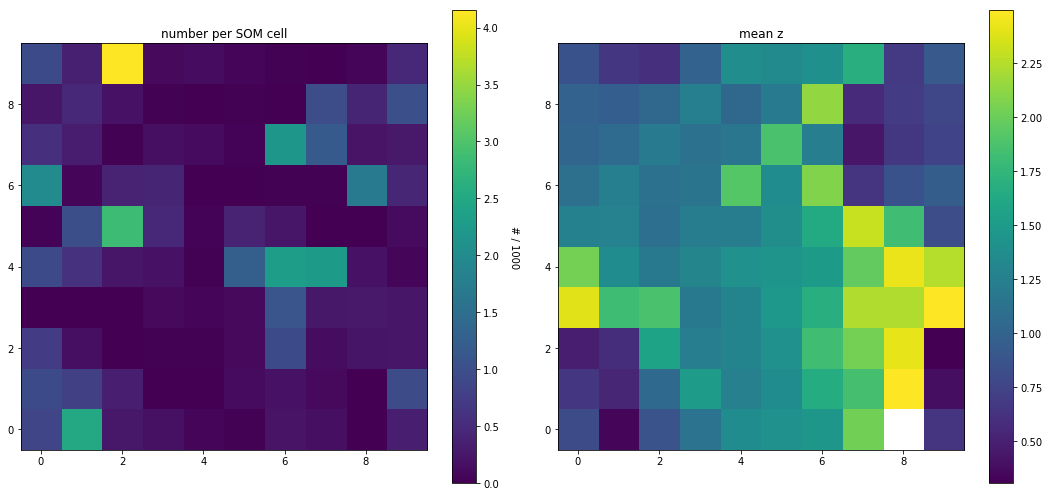

In [159]:
counts = map_galaxies_to_som(colors[::100], redshifts[::100], som_10, statistic=np.mean, scale=1000)

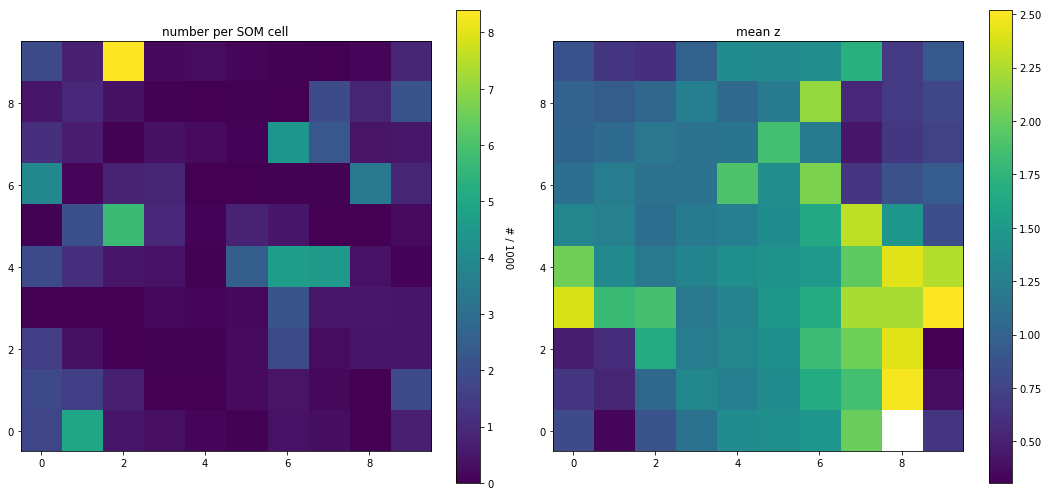

In [160]:
counts = map_galaxies_to_som(colors[::50], redshifts[::50], som_10, statistic=np.mean, scale=1000)

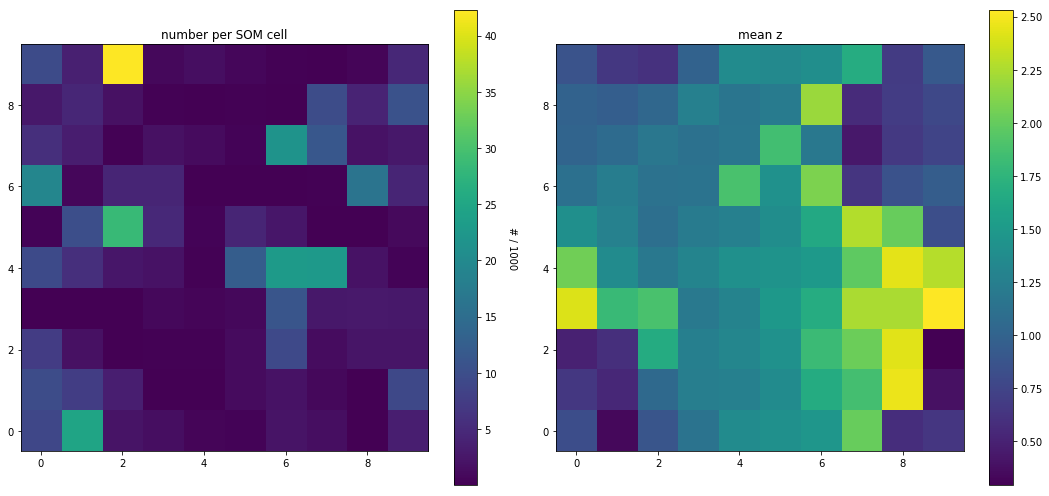

In [161]:
counts = map_galaxies_to_som(colors[::10], redshifts[::10], som_10, statistic=np.mean, scale=1000)

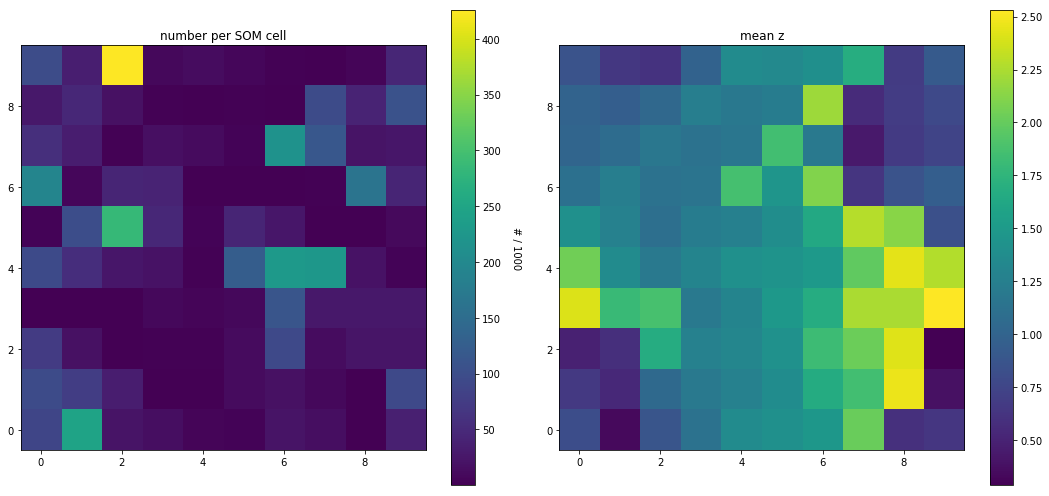

In [162]:
counts = map_galaxies_to_som(colors, redshifts, som_10, statistic=np.mean, scale=1000)

In [ ]:
## Using chi-squared distance to calculated neighborhood
res = -32
start = time.time()
som_10 = galaxy_demo(colors[::100], errs[::100], nmap=res)
print(time.time() - start)

### Now run on DC2 colors

In [ ]:
res = -10
start = time.time()
som_10 = galaxy_demo(df.loc[:,'u-g':'z-y'][::200], nmap=res)
print(time.time() - start)

In [ ]:
for index, row in df[:10].iterrows():
    print(row)

In [ ]:
## make sns.corner plot of u-g, etc colors -- done
## increase colors in SOM -- done
## consider using more galaxies to make the som (then gradually decrease to see how it degrades the som)
## avg/med z in each cell
## min/max/std of z in each cell
## look at masters som paper to get a feel for what paramters to use for SOM

(3, 1024)
119.52241897583008


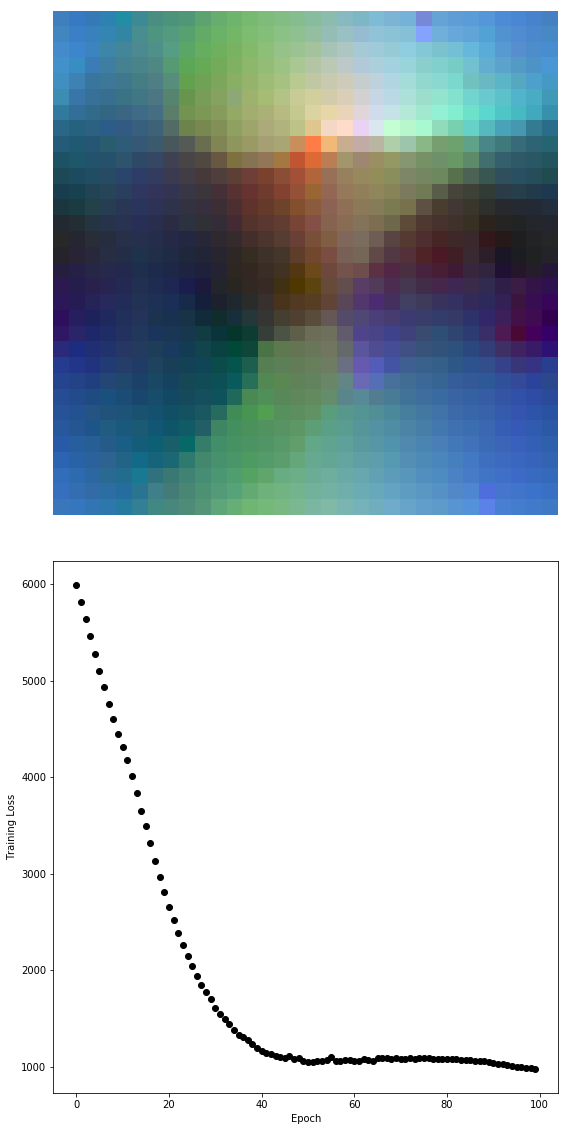

In [73]:
# resolution = 32
start = time.time()
galaxy_som32 = galaxy_demo(colors, nmap=-32)
print(time.time() - start)

Too much variation per cell...try increasing resolution to 50:

(3, 2500)
228.89204001426697


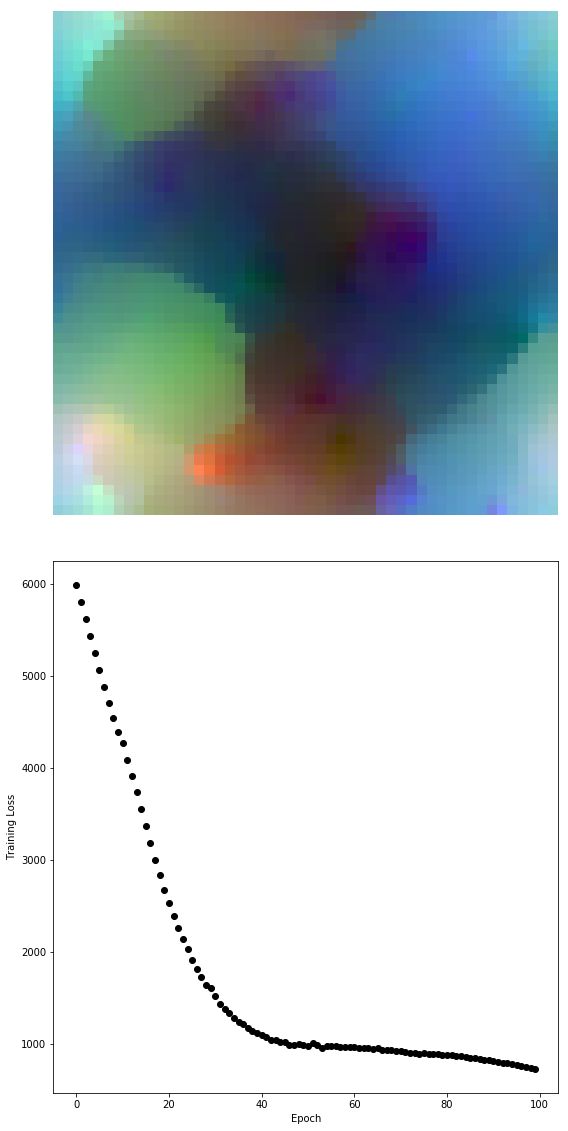

In [122]:
# resolution = 50
res = -50
start = time.time()
galaxy_som50 = galaxy_demo(colors, nmap=res)
print(time.time() - start)

436.99661898612976


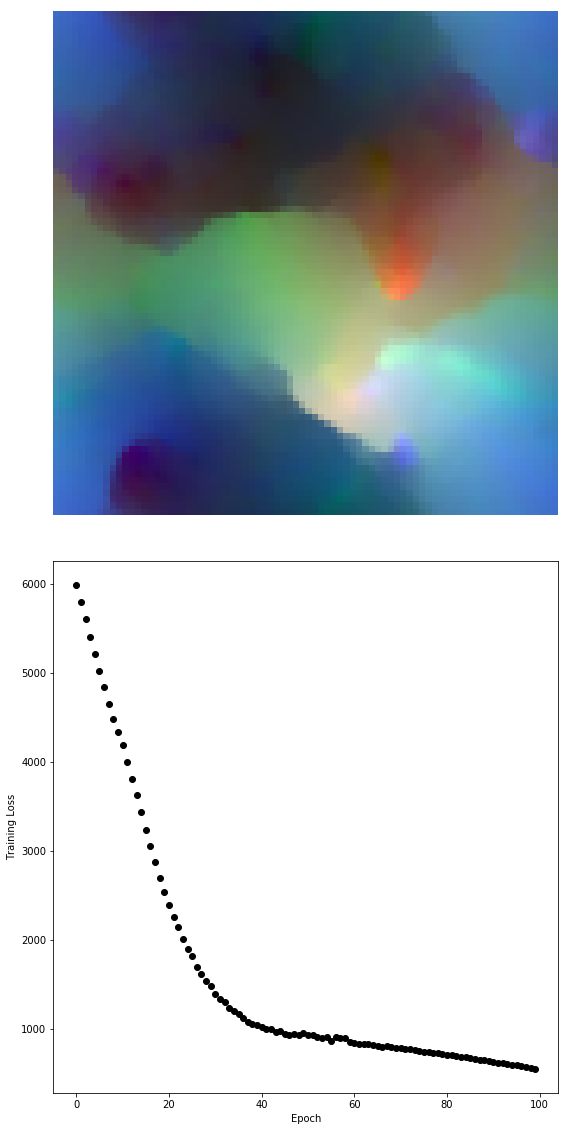

In [138]:
res = -80
start = time.time()
galaxy_som80 = galaxy_demo(colors, nmap=res)
print(time.time() - start)